In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from collections import Counter
import random
import seaborn as sns
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter 
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy import stats
from fitter import Fitter
import matplotlib.cm as cm

In [2]:
# Elegimos cajas cuadradas entre [0, R]
def Puntos_circulos(ncentros, ncircle_points, radio, tcaja, pert, pcenter=0.15, disp_cent=1.5):
    #Definimos dos arreglos de ceros en los que guardaremos en uno las coordenadas x y en otro las y de los puntos que aleatorios de nuestros círculos
    """
    ncentros = numero de centros, numero de circulos
    ncircle_points = numero de puntos por circulo
    radio = tamaño del circulo
    tcaja = tamaño de la caja
    pert = porcentaje de la perturbacion, ruido
    pcenter = porcentaje del numero de puntos en el centro
    disp_cent = dispersion en la distribucion de puntos centro
    """
    
    points_center =  int(ncircle_points*pcenter)
    ran_centros = np.random.uniform(low=0.0, high=tcaja, size=((ncentros,2)))
    x_1, y_1 = ran_centros.T[0], ran_centros.T[1] 
    pts = 0
    circulo = []
    label = []
    for i in range(ncentros):
        cx = []
        cy = []
        ran_pcircles = np.random.uniform(0, 2*np.pi, ncircle_points)
        for j in ran_pcircles:
            r = radio + random.uniform(-radio*pert,radio*pert) #Pertubación
            c_1 = x_1[i] + r*np.cos(j)
            c_2 = y_1[i] + r*np.sin(j)
            #Como los centros de los círculos pueden estar en la orilla, muchos puntos del cículo deseado se pueden 
            #salir de área a estudiar deseada, por lo que sólo guardamos los que quedan dentro
            if (0 < c_1 < tcaja) & (0 < c_2 < tcaja):
                cx.append(c_1)
                cy.append(c_2)
                label.append(i)
                pts+= 1
        #Agregamos puntos en el centro de los círculos con distribución gaussiana
        x = []
        y = []
        x = np.random.normal(x_1[i], disp_cent, points_center)
        y = np.random.normal(y_1[i], disp_cent, points_center)
        for k in range(points_center):
            if (0 < x[k] < tcaja) & (0 < y[k] < tcaja):
                cx.append(x[k])
                cy.append(y[k])
                label.append(i)
                pts+= 1
        # en caso de querer graficar un circulo en particular 
        circulo.append(list(zip(cx, cy)))
    print('total puntos', pts)
    return circulo, label

def DD(circulo):
    # Save them all in one array
    all_data = []
    for i, c in enumerate(circulo):
        for _, j in enumerate(c):
            all_data.append(j)
    return all_data

def centro_masa(n, r):
    return sum(r)/n

#Creamos una función que nos de las distancias entre dos puntos
def distancia(x1, x2):
    diff_x = (x1[0] - x2[0])**2
    diff_y = (x1[1] - x2[1])**2
    r = np.sqrt(diff_x+diff_y)
    return r


def comp_all_distances(sample):
    dist_random = []
    for i, _ in enumerate(sample):
        g = partial(distancia, sample[i]) #partial() recibe una función A con sus respectivos argumentos y retorna una nueva función B que, al ser llamada, equivale a llamar a la función A con los argumentos provistos.
        d = list(map(g, sample[i+1:]))  # Declaración de una lista
        #La función map() toma una función y una lista y aplica esa función a cada elemento de esa lista, produciendo una nueva lista. 
        dist_random.extend(d)
    return dist_random

total puntos 422


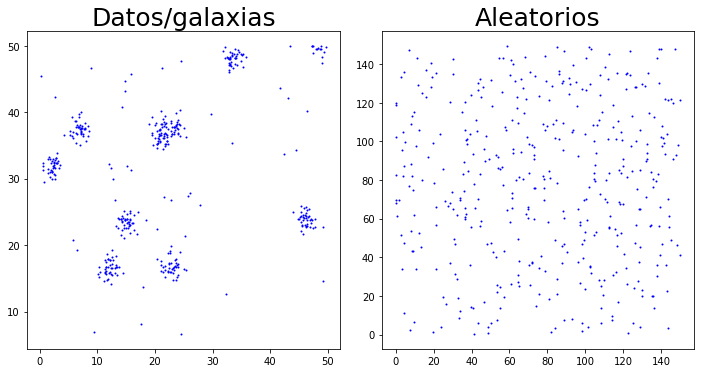

In [77]:
#ncentros, ncircle_points, radio, tcaja, pert, pcenter=0.1, disp_cent=1.5

np.random.seed(431)
#np.random.seed(430) #Tenemos números pseudoaleatorios, así que para obtener el mismo siempre lo sembramos
circulo, etiqueta= Puntos_circulos(10, 5, 10, 50, 0.05, 8.3,1)
DDcirculo = DD(circulo)
N = len(DDcirculo)
rr = np.random.uniform(low=0.0, high=150.0, size=((N,2)))

#Para extraer las coordenadas de nuestras galaxias y el circulo a la que pertenece cada uno
df = pd.DataFrame(DDcirculo)
df.insert(2,'label',etiqueta)
#print(df)
#df.to_csv(r'Shape_5mockgalaxies.txt', header=None, index=None, sep='	', mode='a')

#Importampos los datos
datos = np.zeros((len(DDcirculo),2))
for i in range(len(DDcirculo)):
        datos[i,0] = DDcirculo[i][0]
        datos[i,1] = DDcirculo[i][1]

#Importampos los datos
datosrr = np.zeros((len(rr),2))
for i in range(len(rr)):
        datosrr[i,0] = rr[i][0]
        datosrr[i,1] = rr[i][1]
        
#Plot
fig_cosmo, axes_cosmo = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
plt.tight_layout()

axes_cosmo[0].set_title('Datos/galaxias', fontsize = 25)
for cir in circulo: 
    axes_cosmo[0].scatter(*zip(*cir), color='b', s=1)

axes_cosmo[1].set_title('Aleatorios', fontsize = 25)
axes_cosmo[1].scatter(rr.T[0], rr.T[1], color='b', s=1)

# DBSCAN

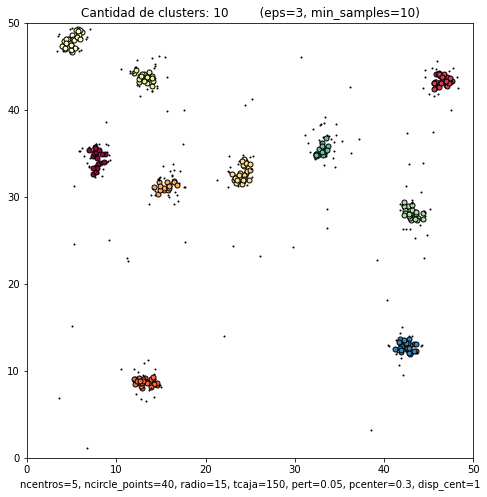

In [12]:
# DBSCAN
db = DBSCAN(eps=1, min_samples=10).fit(datos) #eps=2, min_samples=10
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# número de clusters, ignorando el ruido
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(8,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = datos[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Cantidad de clusters: %d        (eps=3, min_samples=10)' % n_clusters_ )
plt.xlabel('ncentros=5, ncircle_points=40, radio=15, tcaja=150, pert=0.05, pcenter=0.3, disp_cent=1')
plt.xlim(0,50)
plt.ylim(0,50)
plt.show() 

In [5]:
df_cluster_datos = pd.DataFrame(datos)

df_cluster_datos['labels'] = labels

pd.set_option("display.max_rows", None, "display.max_columns", None)

#print(df_cluster_datos)

# Para obtener los indices correpondientes de los puntos de cada cluster
mydict = {i: np.where(labels == i)[0] for i in range(n_clusters_)}

# Transformo el diccionario en una lista 
dictlist = []
list_value = []
for key, value in mydict.items():
    temp = [key,value]
    list_value.append(temp)
    dictlist.append(value)
    
    
cluster_data = [] #Cada cluster_data[i]entrega todos los puntos que pertenecen a ese cluster
for j in mydict.values():
    cluster_data.append(datos[j])
    
centros_clusters = np.zeros((len(cluster_data),2))
for i in range(len(cluster_data)):
        centros_clusters[i,0] = centro_masa(len(cluster_data[i][:,0]), cluster_data[i][:,0])
        centros_clusters[i,1] = centro_masa(len(cluster_data[i][:,1]), cluster_data[i][:,1])

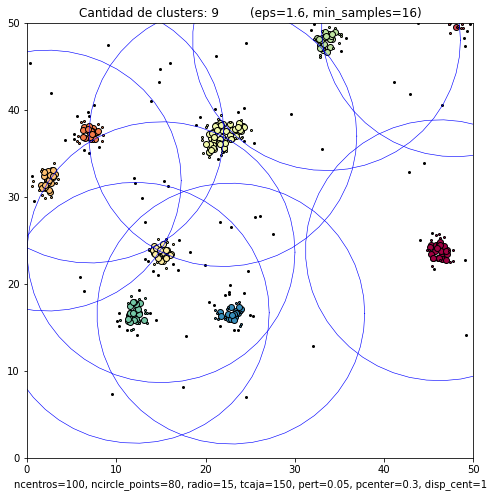

In [6]:
#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(8,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = datos[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = datos[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

plt.title('Cantidad de clusters: %d        (eps=1.6, min_samples=16)' % n_clusters_ )
plt.xlabel('ncentros=100, ncircle_points=80, radio=15, tcaja=150, pert=0.05, pcenter=0.3, disp_cent=1')

r = 15
t = np.linspace(0, 2*np.pi)
for i in range(len(centros_clusters)):
    x = centros_clusters[i,0] + (r * np.cos(t))
    y = centros_clusters[i,1] + (r * np.sin(t))
    plt.plot(x,y, color='b', linewidth=0.6)
plt.xlim(0,50)
plt.ylim(0,50)
plt.show()

# OPTICS

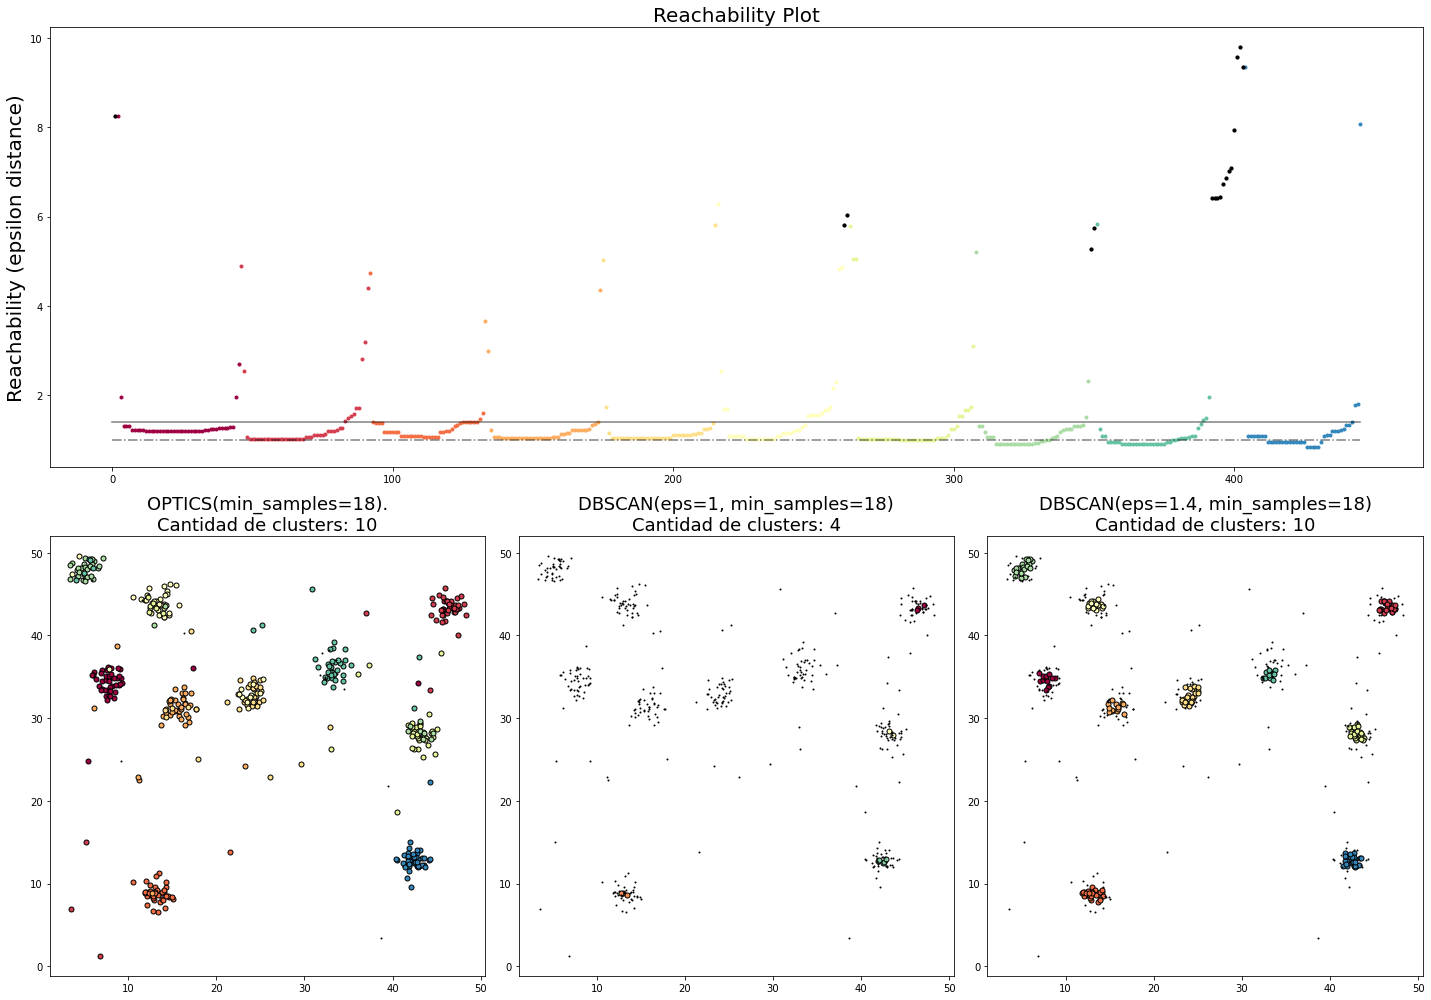

In [21]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec


# OPTICS
clust = OPTICS(min_samples=18, metric='euclidean')

# Run the fit
clust.fit(datos)
space = np.arange(len(datos))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]
# Obtener el número de etiquetas únicas
unique_labels = set(labels)
# Generar la lista de colores utilizando la paleta Spectral
colors = [cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

#DBSCAN
# DBSCAN 1
db_1 = DBSCAN(eps=1, min_samples=18).fit(datos) 
core_samples_mask_1 = np.zeros_like(db_1.labels_, dtype=bool)
core_samples_mask_1[db_1.core_sample_indices_] = True
labels_1 = db_1.labels_
# número de clusters, ignorando el ruido
n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
n_noise_1 = list(labels_1).count(-1)
#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels_1 = set(labels_1)
colors_1 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_1))]

# DBSCAN 2
db_2 = DBSCAN(eps=1.4, min_samples=18).fit(datos) 
core_samples_mask_2 = np.zeros_like(db_2.labels_, dtype=bool)
core_samples_mask_2[db_2.core_sample_indices_] = True
labels_2 = db_2.labels_
# número de clusters, ignorando el ruido
n_clusters_2 = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
n_noise_2 = list(labels_2).count(-1)
#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels_2 = set(labels_2)
colors_2 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_2))]


plt.figure(figsize=(20, 14))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])
# Reachability plot
for klass, color in zip(unique_labels, colors):
    if klass == -1:
        # Si la etiqueta es -1, utilizar negro
        color = [0, 0, 0, 1]
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, ".", color=color, alpha=1)
ax1.plot(space, np.full_like(space,1.4, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 1, dtype=float), "k-.", alpha=0.5)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)", fontsize = 20)
ax1.set_title("Reachability Plot", fontsize = 20)


# OPTICS
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]
        marker_size = 1
    else:
        marker_size = 5

    class_member_mask = (labels == k)

    xy = datos[class_member_mask]
    ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=marker_size )

#ax2.plot(datos[clust.labels_ == -1, 0], datos[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("OPTICS(min_samples=18).\nCantidad de clusters: %d" % n_clusters_, fontsize = 18)

# DBSCAN at 2
for k, col in zip(unique_labels_1, colors_1):
    if k == -1:
        # Si la etiqueta es -1, utilizar negro
        col = [0, 0, 0, 1]

    class_member_mask_1 = (labels_1 == k)

    xy = datos[class_member_mask_1 & core_samples_mask_1]
    ax3.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask_1 & ~core_samples_mask_1]
    ax3.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)
ax3.set_title('DBSCAN(eps=1, min_samples=18)\nCantidad de clusters: %d' % n_clusters_1, fontsize = 18 )

# DBSCAN at 4
for k, col in zip(unique_labels_2, colors_2):
    if k == -1:
        # Si la etiqueta es -1, utilizar negro
        col = [0, 0, 0, 1]

    class_member_mask_2 = (labels_2 == k)

    xy = datos[class_member_mask_2 & core_samples_mask_2]
    ax4.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask_2 & ~core_samples_mask_2]
    ax4.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)
ax4.set_title('DBSCAN(eps=1.4, min_samples=18)\nCantidad de clusters: %d' % n_clusters_2, fontsize = 18 )


plt.tight_layout()
plt.show()

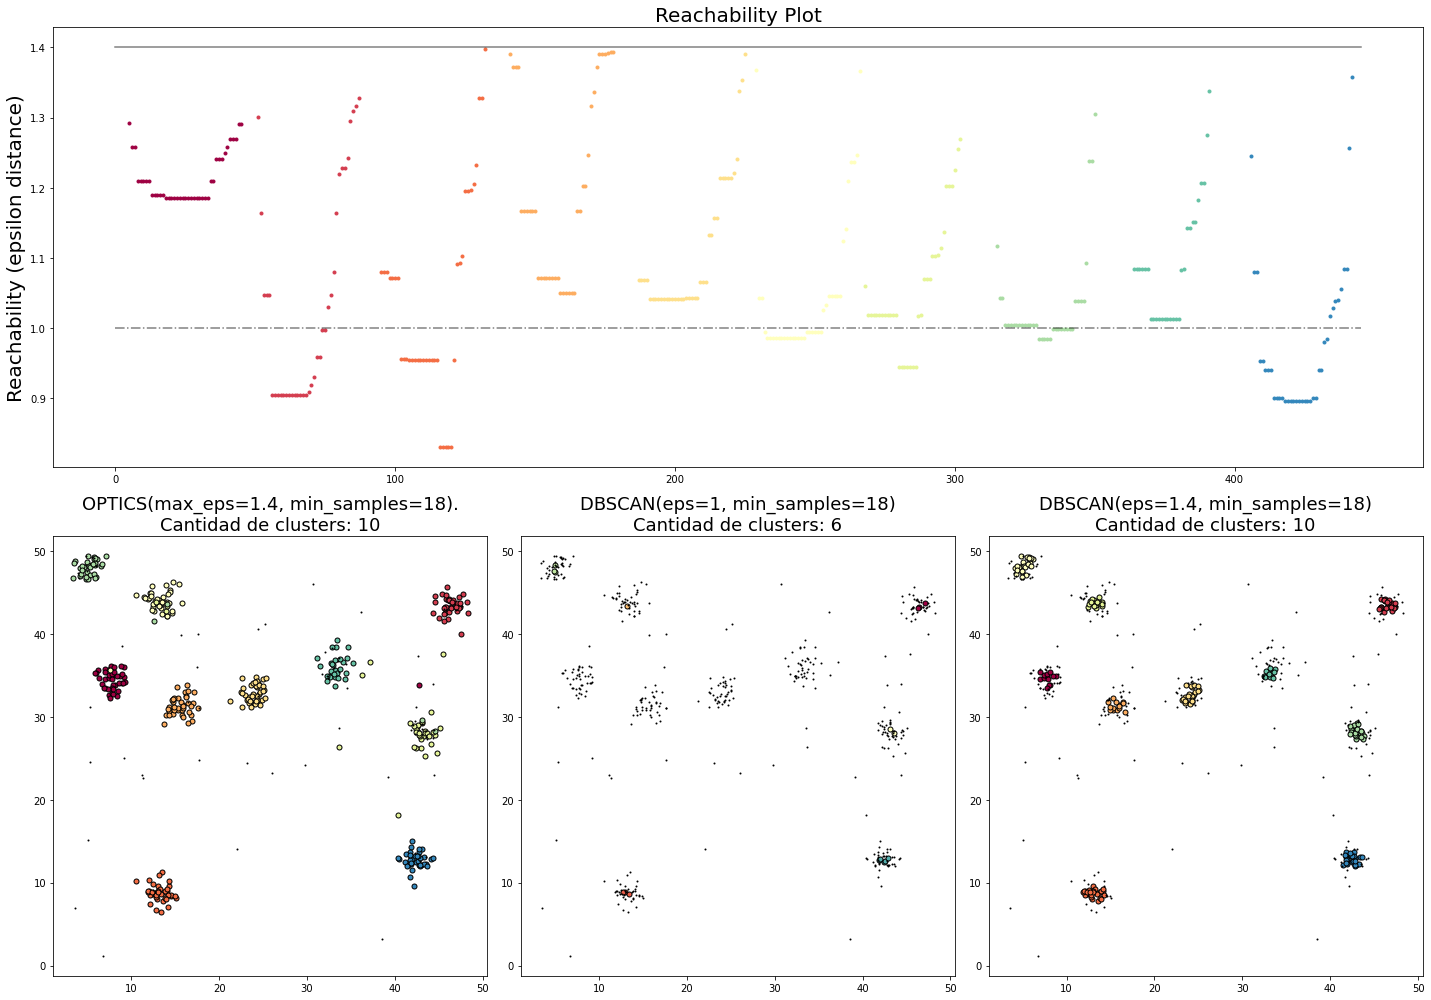

In [27]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec


# OPTICS
clust = OPTICS(max_eps=1.4,min_samples=18, metric='euclidean')

# Run the fit
clust.fit(datos)
space = np.arange(len(datos))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]
# Obtener el número de etiquetas únicas
unique_labels = set(labels)
# Generar la lista de colores utilizando la paleta Spectral
colors = [cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

#DBSCAN
# DBSCAN 1
db_1 = DBSCAN(eps=1, min_samples=18).fit(datos) 
core_samples_mask_1 = np.zeros_like(db_1.labels_, dtype=bool)
core_samples_mask_1[db_1.core_sample_indices_] = True
labels_1 = db_1.labels_
# número de clusters, ignorando el ruido
n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
n_noise_1 = list(labels_1).count(-1)
#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels_1 = set(labels_1)
colors_1 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_1))]

# DBSCAN 2
db_2 = DBSCAN(eps=1.4, min_samples=18).fit(datos) 
core_samples_mask_2 = np.zeros_like(db_2.labels_, dtype=bool)
core_samples_mask_2[db_2.core_sample_indices_] = True
labels_2 = db_2.labels_
# número de clusters, ignorando el ruido
n_clusters_2 = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
n_noise_2 = list(labels_2).count(-1)
#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels_2 = set(labels_2)
colors_2 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_2))]


plt.figure(figsize=(20, 14))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])
# Reachability plot
for klass, color in zip(unique_labels, colors):
    if klass == -1:
        # Si la etiqueta es -1, utilizar negro
        color = [0, 0, 0, 1]
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, ".", color=color, alpha=1)
ax1.plot(space, np.full_like(space,1.4, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 1, dtype=float), "k-.", alpha=0.5)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)", fontsize = 20)
ax1.set_title("Reachability Plot", fontsize = 20)
#ax1.set_ylim(0.5,9)


# OPTICS
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]
        marker_size = 1
    else:
        marker_size = 5

    class_member_mask = (labels == k)

    xy = datos[class_member_mask]
    ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=marker_size )

#ax2.plot(datos[clust.labels_ == -1, 0], datos[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("OPTICS(max_eps=1.4, min_samples=18).\nCantidad de clusters: %d" % n_clusters_, fontsize = 18)

# DBSCAN at 2
for k, col in zip(unique_labels_1, colors_1):
    if k == -1:
        # Si la etiqueta es -1, utilizar negro
        col = [0, 0, 0, 1]

    class_member_mask_1 = (labels_1 == k)

    xy = datos[class_member_mask_1 & core_samples_mask_1]
    ax3.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask_1 & ~core_samples_mask_1]
    ax3.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)
ax3.set_title('DBSCAN(eps=1, min_samples=18)\nCantidad de clusters: %d' % n_clusters_1, fontsize = 18 )

# DBSCAN at 4
for k, col in zip(unique_labels_2, colors_2):
    if k == -1:
        # Si la etiqueta es -1, utilizar negro
        col = [0, 0, 0, 1]

    class_member_mask_2 = (labels_2 == k)

    xy = datos[class_member_mask_2 & core_samples_mask_2]
    ax4.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask_2 & ~core_samples_mask_2]
    ax4.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)
ax4.set_title('DBSCAN(eps=1.4, min_samples=18)\nCantidad de clusters: %d' % n_clusters_2, fontsize = 18 )


plt.tight_layout()
plt.show()

# HDBSCAN

In [14]:
conda update -c conda-forge hdbscan

Note: you may need to restart the kernel to use updated packages.





==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda




Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sammy\Anaconda3

  added / updated specs:
    - hdbscan


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    async_generator-1.10       |             py_0          18 KB  conda-forge
    backports-1.0              |             py_2           4 KB  conda-forge
    backports.functools_lru_cache-1.6.4|     pyhd8ed1ab_0           9 KB  conda-forge
    backports.tempfile-1.0     |             py_0          10 KB  conda-forge
    backports.weakref-1.0.post1|  pyhd8ed1ab_1003          11 KB  conda-forge
    chardet-3.0.4              |        py38_1003         189 KB  conda-forge
    cloudpickle-1.6.0          |             py_0          22 KB  conda-forge
    conda-package-handling-2.0.2|     pyh38be061_0         247 KB  conda-forge
    conda-package-streaming-0.8.0|     pyhd8ed1ab_0          18 KB  con

jsonschema-3.2.0     | 45 KB     | ########## | 100% 

winpty-0.4.3         | 1.1 MB    |            |   0% 
winpty-0.4.3         | 1.1 MB    | 1          |   1% 
winpty-0.4.3         | 1.1 MB    | #8         |  18% 
winpty-0.4.3         | 1.1 MB    | ##6        |  26% 
winpty-0.4.3         | 1.1 MB    | ###3       |  33% 
winpty-0.4.3         | 1.1 MB    | ####1      |  42% 
winpty-0.4.3         | 1.1 MB    | ####8      |  49% 
winpty-0.4.3         | 1.1 MB    | #####5     |  56% 
winpty-0.4.3         | 1.1 MB    | ######2    |  63% 
winpty-0.4.3         | 1.1 MB    | #######1   |  71% 
winpty-0.4.3         | 1.1 MB    | #######7   |  78% 
winpty-0.4.3         | 1.1 MB    | ########4  |  85% 
winpty-0.4.3         | 1.1 MB    | #########7 |  97% 
winpty-0.4.3         | 1.1 MB    | ########## | 100% 

m2w64-gmp-6.1.0      | 726 KB    |            |   0% 
m2w64-gmp-6.1.0      | 726 KB    | 2          |   2% 
m2w64-gmp-6.1.0      | 726 KB    | #1         |  11% 
m2w64-gmp-6.1.0      | 726

In [7]:
#conda update -c conda-forge hdbscan 
# no se encuentra en la librería Scikit-Learn, así queinstalamos su propia librería
import hdbscan
%matplotlib inline

col_0  count
row_0       
-1        20
 0        45
 1        40
 2        43
 3        44
 4        46
 5        41
 6        41
 7        41
 8        44
 9        41


(0.0, 50.0)

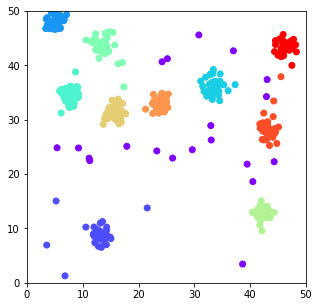

In [11]:
hd = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
hd.fit(datos)

#Number of clusters
print(pd.crosstab(hd.labels_, columns='count'))

#Plot
plt.figure(figsize=(5,5))
plt.scatter(datos[:,0], datos[:,1], c=hd.labels_, cmap='rainbow')
plt.xlim(0,50)
plt.ylim(0,50)

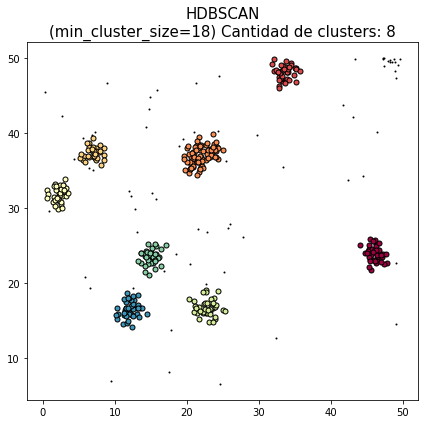

In [98]:
hd = hdbscan.HDBSCAN(min_cluster_size=18, gen_min_span_tree=True)
hd.fit(datos)

# Obtener los resultados de HDBSCAN
labels_hdbscan = hd.labels_
n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(labels_hdbscan)))]

# HDBSCAN
core_samples_mask = np.zeros_like(hd.labels_, dtype=bool)
core_samples_mask[hd.probabilities_ >= 0.5] = True

# Plot de HDBSCAN
plt.figure(figsize=(6, 6))  # Utiliza el último subplot disponible
for k, col in zip(set(labels_hdbscan), colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Negro

    class_member_mask_hdbscan = (labels_hdbscan == k)

    xy_hdbscan = datos[class_member_mask_hdbscan & core_samples_mask]
    plt.plot(xy_hdbscan[:, 0], xy_hdbscan[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy_hdbscan = datos[class_member_mask_hdbscan & ~core_samples_mask]
    plt.plot(xy_hdbscan[:, 0], xy_hdbscan[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('HDBSCAN\n(min_cluster_size=18) Cantidad de clusters: %d' % n_clusters_hdbscan, fontsize=15)


plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='distance'>

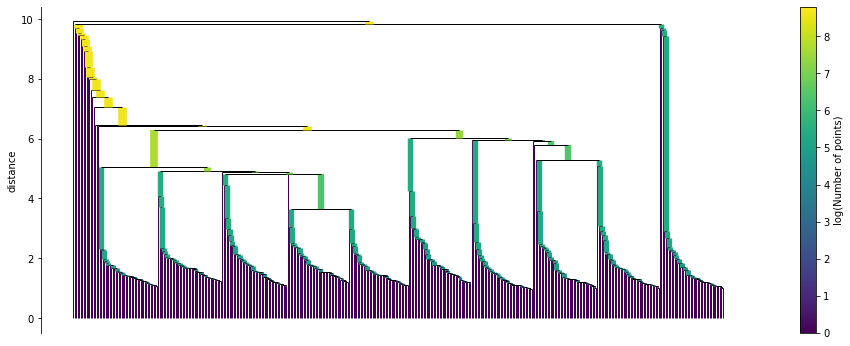

In [81]:
plt.figure(figsize=(16, 6))
hd.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

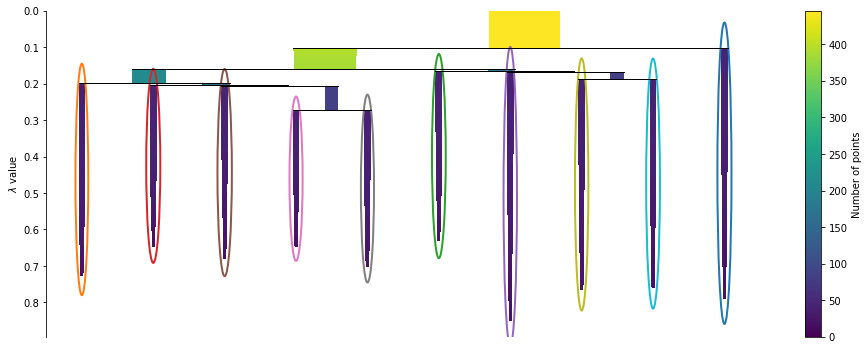

In [78]:
plt.figure(figsize=(16, 6))
hd.condensed_tree_.plot(select_clusters=True,
                              selection_palette=sns.color_palette())

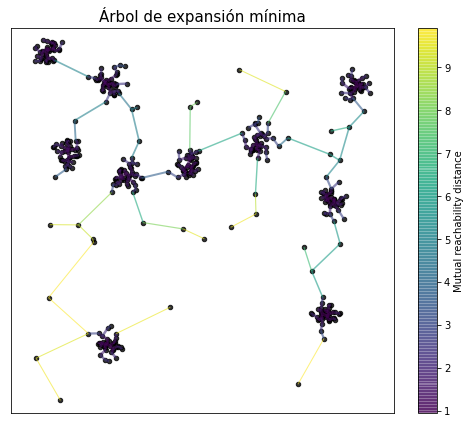

In [76]:
plt.figure(figsize=(7, 6))
plt.title('Árbol de expansión mínima', fontsize=15)
hd.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=20, edge_linewidth=1)
plt.axis('equal') 
plt.tight_layout()
plt.show()

### DBSCAN, OPTICS, HDBSCAN

In [124]:
def calcula_cm(datos, labels, n_clusters_):
    df_cluster_datos = pd.DataFrame(datos)
    df_cluster_datos['labels'] = labels
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    
    # Para obtener los indices correpondientes de los puntos de cada cluster
    mydict = {i: np.where(labels == i)[0] for i in range(n_clusters_)}
    
    # Transformo el diccionario en una lista 
    dictlist = []
    list_value = []
    for key, value in mydict.items():
        temp = [key,value]
        list_value.append(temp)
        dictlist.append(value)
    
    cluster_data = [] #Cada cluster_data[i]entrega todos los puntos que pertenecen a ese cluster
    for j in mydict.values():
        cluster_data.append(datos[j])
    
    centros_clusters = np.zeros((len(cluster_data),2))
    for i in range(len(cluster_data)):
        centros_clusters[i,0] = centro_masa(len(cluster_data[i][:,0]), cluster_data[i][:,0])
        centros_clusters[i,1] = centro_masa(len(cluster_data[i][:,1]), cluster_data[i][:,1])
    return centros_clusters

total puntos 2004


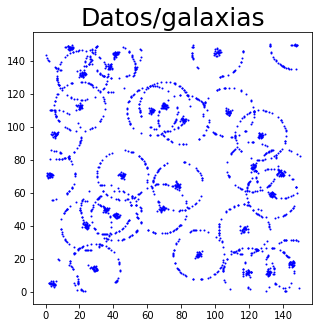

In [175]:
#ncentros, ncircle_points, radio, tcaja, pert, pcenter=0.1, disp_cent=1.5

np.random.seed(431)
#np.random.seed(430) #Tenemos números pseudoaleatorios, así que para obtener el mismo siempre lo sembramos
circulo, etiqueta= Puntos_circulos(30, 50, 15, 150, 0, 0.5,1)
DDcirculo = DD(circulo)
N = len(DDcirculo)
rr = np.random.uniform(low=0.0, high=150.0, size=((N,2)))

#Para extraer las coordenadas de nuestras galaxias y el circulo a la que pertenece cada uno
df = pd.DataFrame(DDcirculo)
df.insert(2,'label',etiqueta)
#print(df)
#df.to_csv(r'Shape_5mockgalaxies.txt', header=None, index=None, sep='	', mode='a')

#Importampos los datos
datos = np.zeros((len(DDcirculo),2))
for i in range(len(DDcirculo)):
        datos[i,0] = DDcirculo[i][0]
        datos[i,1] = DDcirculo[i][1]

#Importampos los datos
datosrr = np.zeros((len(rr),2))
for i in range(len(rr)):
        datosrr[i,0] = rr[i][0]
        datosrr[i,1] = rr[i][1]
        
#Plot
plt.subplots(figsize=(5,5))
plt.title('Datos/galaxias', fontsize = 25)
for cir in circulo: 
    plt.scatter(*zip(*cir), color='b', s=1)

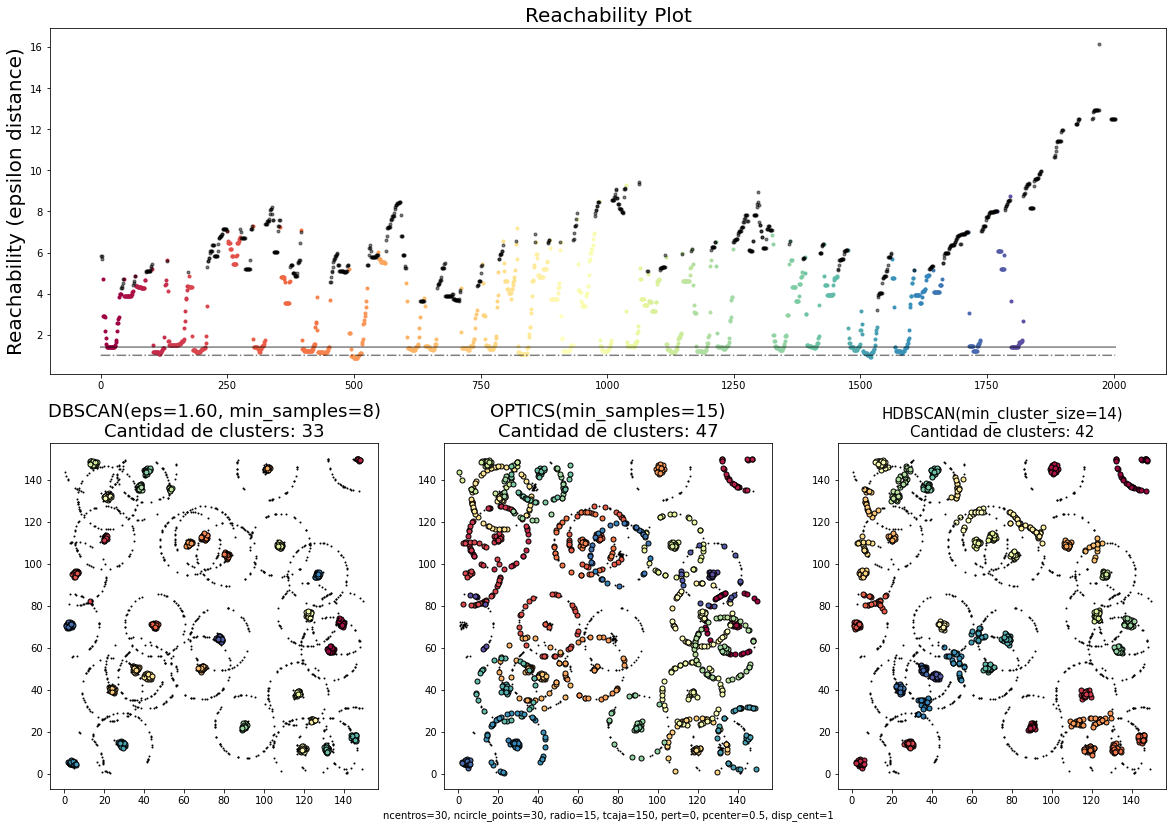

<Figure size 432x432 with 0 Axes>

In [179]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
#dbscan
a=1.6 #eps
b=8   #min samples
#optices
c=15  #min samples
d=2 #max eps 
#hdbscan
e=14 #min_cluster_size

#DBSCAN
# DBSCAN 1
db_1 = DBSCAN(eps=a, min_samples=b).fit(datos) 
core_samples_mask_1 = np.zeros_like(db_1.labels_, dtype=bool)
core_samples_mask_1[db_1.core_sample_indices_] = True
labels_1 = db_1.labels_
# número de clusters, ignorando el ruido
n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
n_noise_1 = list(labels_1).count(-1)
#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels_1 = set(labels_1)
colors_1 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_1))]
##################################################################################################################
# OPTICS
clust = OPTICS(min_samples=c, metric='euclidean')

# Run the fit
clust.fit(datos)
space = np.arange(len(datos))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]
# Obtener el número de etiquetas únicas
unique_labels = set(labels)
# Generar la lista de colores utilizando la paleta Spectral
colors = [cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
#Numero de clusters
n_clusters_o = len(set(labels)) - (1 if -1 in labels_1 else 0)

######################################################################################################################
#HDBSCAN

hd = hdbscan.HDBSCAN(min_cluster_size=e, gen_min_span_tree=True)
hd.fit(datos)

# Obtener los resultados de HDBSCAN
labels_hdbscan = hd.labels_
n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(labels_hdbscan)))]

core_samples_mask = np.zeros_like(hd.labels_, dtype=bool)
core_samples_mask[hd.probabilities_ >= 0.5] = True


#######################################################################################################################

#PLOT
plt.figure(figsize=(20, 14))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
for klass, color in zip(unique_labels, colors):
    if klass == -1:
        # Si la etiqueta es -1, utilizar negro
        color = [0, 0, 0, 1]
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, ".", color=color, alpha=1)
ax1.plot(space, np.full_like(space,1.4, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 1, dtype=float), "k-.", alpha=0.5)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)", fontsize = 20)
ax1.set_title("Reachability Plot", fontsize = 20)
#ax1.set_ylim(0,9)

# PLOT DBSCAN 
for k, col in zip(unique_labels_1, colors_1):
    if k == -1:
        # Si la etiqueta es -1, utilizar negro
        col = [0, 0, 0, 1]

    class_member_mask_1 = (labels_1 == k)

    xy = datos[class_member_mask_1 & core_samples_mask_1]
    ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask_1 & ~core_samples_mask_1]
    ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)
ax2.set_title('DBSCAN(eps=%.2f, min_samples=%d)\nCantidad de clusters: %d' %(a, b, n_clusters_1), fontsize = 18 )
ax3.set_xlabel("ncentros=30, ncircle_points=50, radio=15, tcaja=150, pert=0, pcenter=0.5, disp_cent=1", fontsize = 10)

# OPTICS PLOT
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]
        marker_size = 1
    else:
        marker_size = 5

    class_member_mask = (labels == k)

    xy = datos[class_member_mask]
    ax3.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=marker_size )
for cir in circulo: 
    ax3.scatter(*zip(*cir), color='black', s=0.8)

#ax2.plot(datos[clust.labels_ == -1, 0], datos[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax3.set_title("OPTICS(min_samples=%d)\nCantidad de clusters: %d" %(c,n_clusters_o), fontsize = 18)
ax3.set_xlabel("ncentros=30, ncircle_points=30, radio=15, tcaja=150, pert=0, pcenter=0.5, disp_cent=1", fontsize = 10)


# Plot de HDBSCAN
plt.figure(figsize=(6, 6))  # Utiliza el último subplot disponible
for k, col in zip(set(labels_hdbscan), colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Negro

    class_member_mask_hdbscan = (labels_hdbscan == k)

    xy_hdbscan = datos[class_member_mask_hdbscan & core_samples_mask]
    ax4.plot(xy_hdbscan[:, 0], xy_hdbscan[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy_hdbscan = datos[class_member_mask_hdbscan & ~core_samples_mask]
    ax4.plot(xy_hdbscan[:, 0], xy_hdbscan[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

ax4.set_title('HDBSCAN(min_cluster_size=%d)\nCantidad de clusters: %d' %(e, n_clusters_hdbscan), fontsize=15)


plt.tight_layout()

In [180]:
centros_dbscan = calcula_cm(datos, labels_1, n_clusters_1)
centros_optics = calcula_cm(datos, labels, n_clusters_o)
centros_hdbscan = calcula_cm(datos, labels_hdbscan, n_clusters_hdbscan)

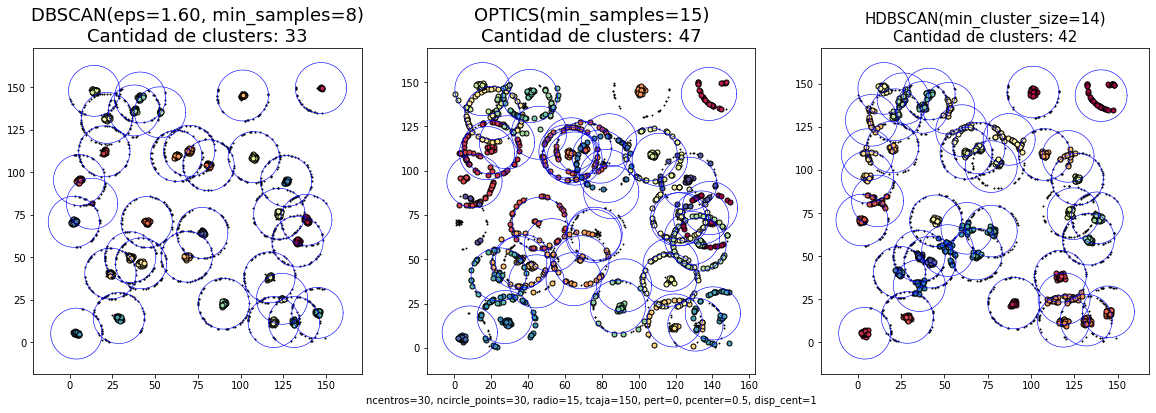

<Figure size 432x432 with 0 Axes>

In [181]:

#PLOT
plt.figure(figsize=(20, 6))
G = gridspec.GridSpec(1, 3)
ax2 = plt.subplot(G[0, 0])
ax3 = plt.subplot(G[0, 1])
ax4 = plt.subplot(G[0, 2])

# PLOT DBSCAN 
for k, col in zip(unique_labels_1, colors_1):
    if k == -1:
        # Si la etiqueta es -1, utilizar negro
        col = [0, 0, 0, 1]

    class_member_mask_1 = (labels_1 == k)

    xy = datos[class_member_mask_1 & core_samples_mask_1]
    ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask_1 & ~core_samples_mask_1]
    ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)
ax2.set_title('DBSCAN(eps=%.2f, min_samples=%d)\nCantidad de clusters: %d' %(a, b, n_clusters_1), fontsize = 18 )
#centros
r = 15
t = np.linspace(0, 2*np.pi)
for i in range(len(centros_dbscan)):
    x = centros_dbscan[i,0] + (r * np.cos(t))
    y = centros_dbscan[i,1] + (r * np.sin(t))
    ax2.plot(x,y, color='b', linewidth=0.6)

# OPTICS PLOT
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]
        marker_size = 1
    else:
        marker_size = 5

    class_member_mask = (labels == k)

    xy = datos[class_member_mask]
    ax3.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=marker_size )
    
for cir in circulo: 
    ax3.scatter(*zip(*cir), color='black', s=0.8)

#ax2.plot(datos[clust.labels_ == -1, 0], datos[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax3.set_title("OPTICS(min_samples=%d)\nCantidad de clusters: %d" %(c,n_clusters_o), fontsize = 18)
ax3.set_xlabel("ncentros=30, ncircle_points=30, radio=15, tcaja=150, pert=0, pcenter=0.5, disp_cent=1", fontsize = 10)
#centros
r = 15
t = np.linspace(0, 2*np.pi)
for i in range(len(centros_optics)):
    x = centros_optics[i,0] + (r * np.cos(t))
    y = centros_optics[i,1] + (r * np.sin(t))
    ax3.plot(x,y, color='b', linewidth=0.6)


# Plot de HDBSCAN
plt.figure(figsize=(6, 6))  # Utiliza el último subplot disponible
for k, col in zip(set(labels_hdbscan), colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Negro

    class_member_mask_hdbscan = (labels_hdbscan == k)

    xy_hdbscan = datos[class_member_mask_hdbscan & core_samples_mask]
    ax4.plot(xy_hdbscan[:, 0], xy_hdbscan[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy_hdbscan = datos[class_member_mask_hdbscan & ~core_samples_mask]
    ax4.plot(xy_hdbscan[:, 0], xy_hdbscan[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

ax4.set_title('HDBSCAN(min_cluster_size=%d)\nCantidad de clusters: %d' %(e, n_clusters_hdbscan), fontsize=15)
#centros
r = 15
t = np.linspace(0, 2*np.pi)
for i in range(len(centros_hdbscan)):
    x = centros_hdbscan[i,0] + (r * np.cos(t))
    y = centros_hdbscan[i,1] + (r * np.sin(t))
    ax4.plot(x,y, color='b', linewidth=0.6)


plt.tight_layout()

In [100]:
df_cluster_datos = pd.DataFrame(datos)

df_cluster_datos['labels'] = labels

pd.set_option("display.max_rows", None, "display.max_columns", None)

print(df_cluster_datos)

               0           1  labels
0     122.311927    0.442809      -1
1     142.525071   23.327377      -1
2     146.652420    5.552675      -1
3     123.731902   23.718932      -1
4     140.502408   23.638994      -1
5     117.747849   13.542517      -1
6     119.361398   19.049601      -1
7     148.207076    8.559001      -1
8     147.793154   10.608308      -1
9     119.793003    2.776343      -1
10    117.423860   12.996400      -1
11    146.775432    4.562163      -1
12    117.589974    9.956056      -1
13    119.229276    4.253049      -1
14    120.611962    1.936689      -1
15    144.217445    1.712646      -1
16    141.125639   24.453409      -1
17    126.586241   24.593291      -1
18    121.216033    1.095894      -1
19    130.543551   25.583890      -1
20    147.485039    6.487272      -1
21    121.339542   20.812971      -1
22    118.101487    8.982252      -1
23    148.270765   10.945639      -1
24    121.707876   21.913200      -1
25    139.589954   25.600422      -1
2

Fitting 6 distributions:  50%|█████████████████████████████▌                             | 3/6 [00:30<00:26,  8.73s/it]SKIPPED beta distribution (taking more than 30 seconds)
SKIPPED gamma distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitting 6 distributions: 100%|███████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.02s/it]
chi2 was not fitted. no parameters available
beta was not fitted. no parameters available
gamma was not fitted. no parameters available


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
rayleigh,0.000062,1184.417151,-4.506863e+07,0.015908,0.038133,0.0
cauchy,0.000505,1199.641425,-4.113711e+07,0.109917,0.104993,0.0
chi2,inf,inf,inf,inf,NaN,NaN
beta,inf,inf,inf,inf,NaN,NaN
gamma,inf,inf,inf,inf,NaN,NaN


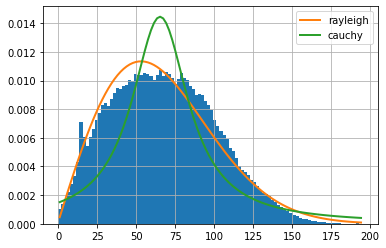

In [84]:
#distancias
distance_dd = comp_all_distances(DDcirculo)
dist_fitter = Fitter(distance_dd,
                   distributions = ["cauchy",
                                    "rayleigh",
                                    "chi2",
                                    "beta",
                                    "gamma",
                                    "lognorm"])       
dist_fitter.fit()
dist_fitter.summary()     